# **CA#6 Part 2 -  NLP Course**
Parnian Fazel, Sheyda Eshaghi

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -av "/content/drive/MyDrive/NLP CA6/Dataset" . 

'/content/drive/MyDrive/NLP CA6/Dataset' -> './Dataset'
'/content/drive/MyDrive/NLP CA6/Dataset/fa-IR.jsonl' -> './Dataset/fa-IR.jsonl'


# **Installing Dependencies**

In [3]:
!pip install transformers
!pip install datasets
!pip install torch
!pip install seqeval
!pip install ruamel.yaml
!pip install sentencepiece
!pip install ray
!pip install -r req.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.8 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 6.6 MB 47.7 MB/s 
     |████████████████████████████████| 596 kB 65.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 7.4 MB/s 
     |████████████████████████████████| 212 kB 52.3 MB/s 
     |████████████████████████████████| 140 kB 42.1 MB/s 
     |████████████████████████████████| 1.1 MB 22.1 MB/s 
     |████████████████████████████████| 127 kB 59.6 MB/s 
     |████████████████████████████████| 271 kB 60.1 MB/s 
     |████████████████████████████████| 94 kB 759 kB/s 
     |█████████████

In [4]:
import pandas as pd
import json
import datasets
from datasets import Dataset
import argparse
import os
from tqdm import tqdm
import torch

# **Study Dataset**

## **Pars Input Json File**

In [ ]:
def isascii(s):
    try:
        return s.isascii()
    except AttributeError:
        return all([ord(c) < 128 for c in s])
def get_massive_raw_data():
  massive_raw = []
  # Read in the json per line
  with open('/content/Dataset/fa-IR.jsonl', 'r') as f:
      for line in f:
          massive_raw.append(json.loads(line))
  return massive_raw

def _build_in_mem_dicts(massive_data):
    """ Parse the JSON into a flat key/value format """
    char_split = ['fa-IR']
    cols = ['id', 'locale', 'domain', 'intent_str', 'annot_utt', 'utt', 'slots_str']
    train, dev = {k: [] for k in cols}, {k: [] for k in cols}
    test, hid_eval = {k: [] for k in cols}, {k: [] for k in cols}
    for row in massive_data:
        domain, intent, utt, locale = row['scenario'], row['intent'], row['utt'], row['locale']
        annot_utt, eyed, split = row['annot_utt'], row['id'], row['partition']
        # Split these languages by character
        if locale in char_split:
            tokens, labels = [], []
            label = 'Other'
            skip_colon = False
            for chunk in annot_utt.split():
                if chunk.startswith('['):
                    label = chunk.lstrip('[')
                    skip_colon = True
                    continue
                if chunk == ':' and skip_colon is True:
                    skip_colon = False
                    continue
                # keep latin chars together in cases of code switching
                if isascii(chunk):
                    tokens.append(chunk.strip().rstrip(']'))
                    labels.append(label)
                else:
                    chars = list(chunk.strip())
                    for char in chars:
                        if char == ']':
                            label = 'Other'
                        else:
                            tokens.append(char)
                            labels.append(label)
        else:
            # Create the tokens and labels by working left to right of annotated utt
            tokens = utt.split()
            labels = []
            label = 'Other'
            split_annot_utt = annot_utt.split()
            idx = 0
            while idx < len(split_annot_utt):
                if split_annot_utt[idx].startswith('['):
                    label = split_annot_utt[idx].lstrip('[')
                    idx += 2
                elif split_annot_utt[idx].endswith(']'):
                    labels.append(label)
                    label = 'Other'
                    idx += 1
                else:
                    labels.append(label)
                    idx += 1

        if len(tokens) != len(labels):
            raise ValueError(f"Len of tokens, {tokens}, doesnt match len of labels, {labels}, "
                              f"for id {eyed} and annot utt: {annot_utt}")

        # Pick the dictionary corresponding to this split
        if split == 'train':
            dict_view = train
        elif split == 'dev':
            dict_view = dev
        elif split == 'test':
            dict_view = test
        elif split == 'heldout':
            dict_view = hid_eval
        else:
            raise ValueError(f"split {split} is not valid")

        # add the values for the keys
        dict_view['id'].append(eyed)
        dict_view['locale'].append(locale)
        dict_view['domain'].append(domain)
        dict_view['intent_str'].append(intent)
        dict_view['annot_utt'].append(annot_utt)
        dict_view['utt'].append(tokens)
        dict_view['slots_str'].append(labels)
    return train, dev, test, hid_eval
train, dev, test, hid_eval = _build_in_mem_dicts(get_massive_raw_data())

In [ ]:
df = pd.DataFrame.from_dict(dev)
df.head(20)

,id,locale,domain,intent_str,annot_utt,utt,slots_str
0,11,fa-IR,iot,iot_hue_lightoff,لطفا لامپ ها را خاموش کن,"[ل, ط, ف, ا, ل, ا, م, پ, ه, ا, ر, ا, خ, ا, م, ...","[Other, Other, Other, Other, Other, Other, Oth..."
1,17,fa-IR,iot,iot_hue_lightdim,لامپ ها را در [house_place : هال] کم کن,"[ل, ا, م, پ, ه, ا, ر, ا, د, ر, ه, ا, ل, ک, م, ...","[Other, Other, Other, Other, Other, Other, Oth..."
2,24,fa-IR,iot,iot_hue_lightdim,[house_place : اتاق] را تاریکتر بکن,"[ا, ت, ا, ق, ر, ا, ت, ا, ر, ی, ک, ت, ر, ب, ک, ن]","[house_place, house_place, house_place, house_..."
3,26,fa-IR,iot,iot_cleaning,[house_place : همکف] را تمیز کن,"[ه, م, ک, ف, ر, ا, ت, م, ی, ز, ک, ن]","[house_place, house_place, house_place, house_..."
4,30,fa-IR,iot,iot_cleaning,تمیز کردن خوب است گردو غبار خیلی بد است اکنون ...,"[ت, م, ی, ز, ک, ر, د, ن, خ, و, ب, ا, س, ت, گ, ...","[Other, Other, Other, Other, Other, Other, Oth..."
5,42,fa-IR,general,general_quirky,وضعیت را در حافظه در دسترس من به من بدهید,"[و, ض, ع, ی, ت, ر, ا, د, ر, ح, ا, ف, ظ, ه, د, ...","[Other, Other, Other, Other, Other, Other, Oth..."
6,53,fa-IR,takeaway,takeaway_query,غذای [food_type : چینی] [order_type : تحویل] د...,"[غ, ذ, ا, ی, چ, ی, ن, ی, ت, ح, و, ی, ل, د, ر, ...","[Other, Other, Other, Other, food_type, food_t..."
7,58,fa-IR,takeaway,takeaway_query,غذای [food_type : تایلندی] [order_type : بیرون...,"[غ, ذ, ا, ی, ت, ا, ی, ل, ن, د, ی, ب, ی, ر, و, ...","[Other, Other, Other, Other, food_type, food_t..."
8,67,fa-IR,play,play_music,من دوس دارم آهنگ [song_name : آزادی] [artist_n...,"[م, ن, د, و, س, د, ا, ر, م, آ, ه, ن, گ, آ, ز, ...","[Other, Other, Other, Other, Other, Other, Oth..."
9,68,fa-IR,play,play_music,[song_name : کافر] از [artist_name : سامان جلی...,"[ک, ا, ف, ر, ا, ز, س, ا, م, ا, ن, ج, ل, ی, ل, ...","[song_name, song_name, song_name, song_name, O..."


## **Statistics of Dataset(fa-IR.jsonl)**

In [ ]:
import ast
intent_dict = ast.literal_eval(open('data.intents').read())
slot_dict = ast.literal_eval(open('data.slots').read())
intents = list(intent_dict.values())
slots = list(slot_dict.values())
print("Number of All Intents:",len(intents))
print("Number of All  Slots:",len(slots))
print("="*30)
print("----> Intents:")
print('\n'.join(intents))
print("="*30)
print("----> Slots:")
print('\n'.join(slots))

Number of All Intents: 60
Number of All  Slots: 56
----> Intents:
recommendation_locations
play_music
iot_cleaning
email_addcontact
datetime_convert
transport_ticket
qa_stock
lists_query
email_query
datetime_query
calendar_remove
iot_wemo_off
recommendation_events
email_sendemail
qa_maths
general_quirky
calendar_query
iot_hue_lighton
audio_volume_other
takeaway_order
transport_query
weather_query
alarm_set
qa_factoid
play_radio
lists_remove
qa_currency
news_query
lists_createoradd
general_greet
social_query
iot_hue_lightchange
iot_hue_lightdim
calendar_set
iot_hue_lightup
recommendation_movies
play_audiobook
alarm_query
audio_volume_up
cooking_recipe
iot_wemo_on
social_post
qa_definition
audio_volume_mute
general_joke
iot_hue_lightoff
music_dislikeness
transport_traffic
takeaway_query
play_podcasts
iot_coffee
audio_volume_down
play_game
transport_taxi
email_querycontact
music_query
cooking_query
music_likeness
music_settings
alarm_remove
----> Slots:
transport_agency
playlist_name
hous

In [ ]:
def count_column_frequency(col_name, unique_elements):
  partitions_str = ["train", "dev", "test"]
  partitions = [train, dev, test]
  freq = dict(dict())
  freq = {"train": {}, "dev": {}, "test": {}}
  for p in range(len(partitions)):
    for i in range(len(partitions[p][col_name])):
      for element in unique_elements:
        freq[partitions_str[p]][element] = 0

  for p in range(len(partitions)):
    for i in range(len(partitions[p][col_name])):
      record = partitions[p][col_name][i]
      for element in unique_elements:
        if element == record:
          freq[partitions_str[p]][element] += 1
  return freq

def count_slots_frequency():
  partitions_str = ["train", "dev", "test"]
  partitions = [train, dev, test]
  slot_freq = dict(dict())
  slot_freq = {"train": {}, "dev": {}, "test": {}}
  for p in range(len(partitions)):
    for i in range(len(partitions[p]["annot_utt"])):
      record = list(partitions[p]["annot_utt"][i].replace('[', ' ').split())
      for slot in slots:
        slot_freq[partitions_str[p]][slot] = 0

  for p in range(len(partitions)):
    for i in range(len(partitions[p]["annot_utt"])):
      record = list(partitions[p]["annot_utt"][i].replace('[', ' ').split())
      for slot in slots:
        if slot in record:
          slot_freq[partitions_str[p]][slot] += 1
  return slot_freq

domain_freq = count_column_frequency("domain", list(set(list(train["domain"]))))
intent_freq = count_column_frequency("intent_str", intents)
slot_freq = count_slots_frequency()

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
def plot_results(freq, plot_type=0): # type 0 -> plot slot, type 1 -> plot intent
  type_str = "Slot" if plot_type == 0 else "Intent" if plot_type == 1 else "Domain"
  plt.style.use('seaborn')
  plt.figure(figsize=(18, 10))
  X = list(freq["train"].keys())
  X_axis = np.arange(len(X))
  plt.bar(X_axis - 0.3, freq["train"].values(), 0.2, label = 'Train')
  plt.bar(X_axis - 0.1, freq["dev"].values(), 0.2, label = 'Dev')
  plt.bar(X_axis + 0.1, freq["test"].values(), 0.2, label = 'Test')

  plt.xticks(X_axis, X, rotation=90, fontsize=15)
  plt.xlabel(f"{type_str}",  fontsize=18)
  plt.ylabel("Frequency",  fontsize=18)
  plt.title(f"Frequency of {type_str}",  fontsize=18)
  plt.legend()
  plt.tight_layout()
  plt.show()

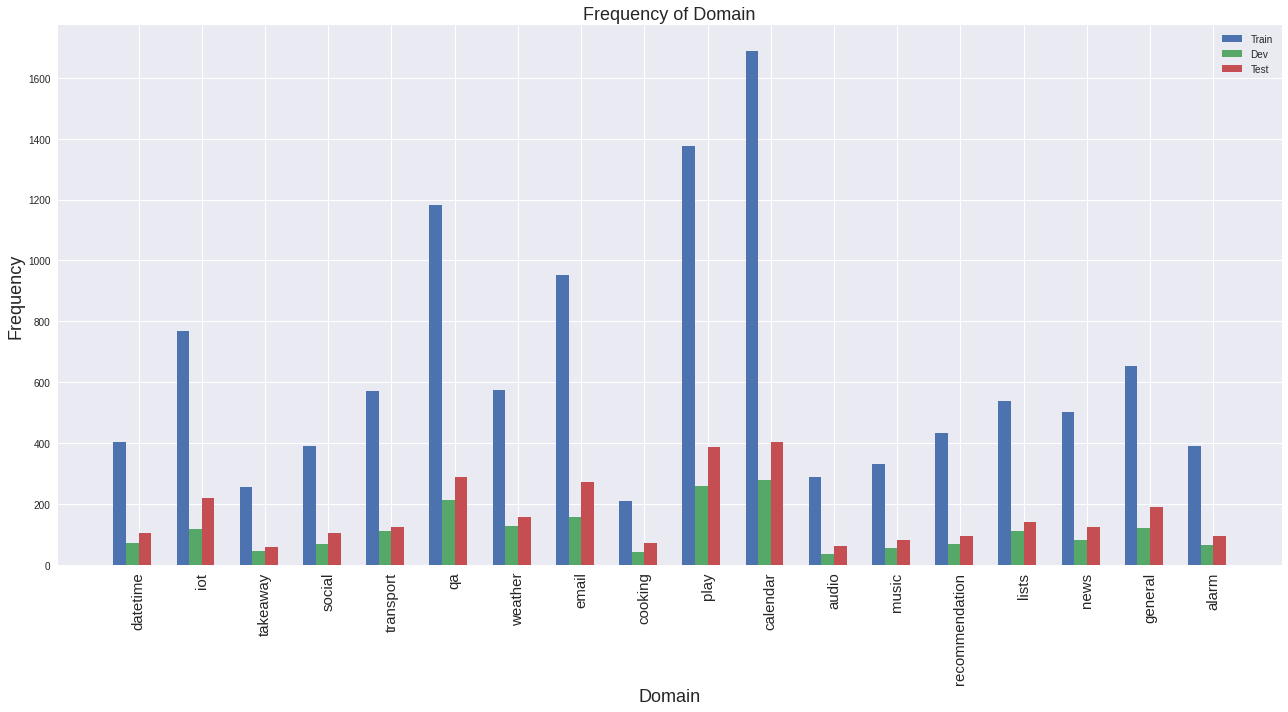

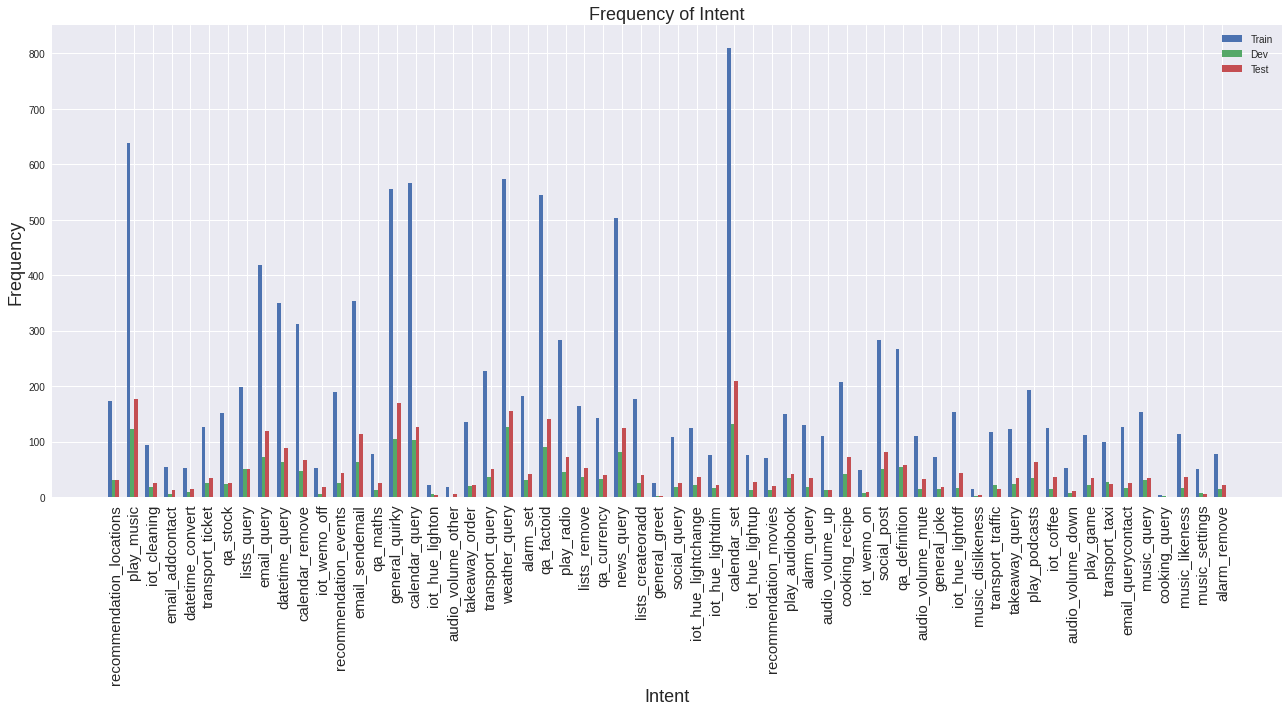

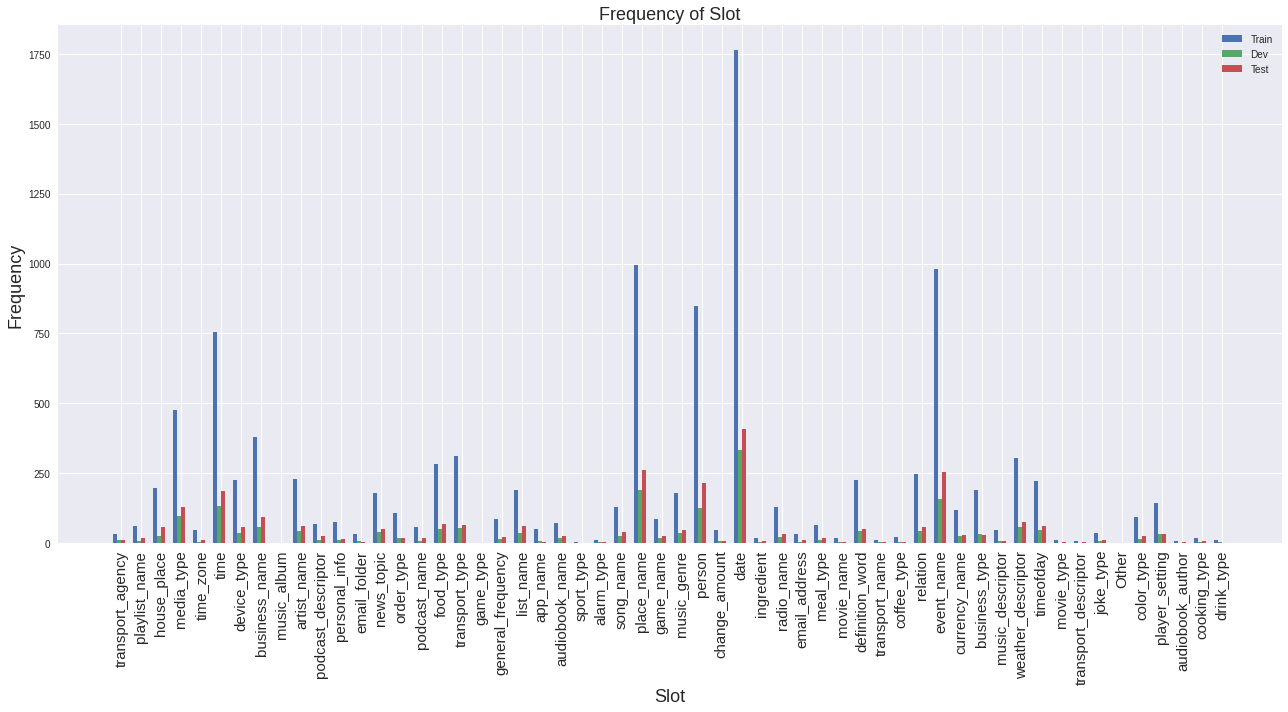

In [ ]:
plot_results(domain_freq, 2)
print("\n\n\n")
plot_results(intent_freq, 1)
print("\n\n\n")
plot_results(slot_freq, 0)

In [ ]:
pd.DataFrame(domain_freq)

,train,dev,test
datetime,402,73,103
iot,769,118,220
takeaway,257,44,57
social,391,68,106
transport,571,110,124
qa,1183,214,288
weather,573,126,156
email,953,157,271
cooking,211,43,72
play,1377,260,387


In [ ]:
pd.DataFrame(intent_freq)

,train,dev,test
recommendation_locations,173,31,31
play_music,639,123,176
iot_cleaning,93,19,26
email_addcontact,54,5,12
datetime_convert,52,9,15
transport_ticket,127,25,35
qa_stock,152,24,26
lists_query,198,50,51
email_query,418,73,119
datetime_query,350,64,88


In [ ]:
pd.DataFrame(slot_freq)

,train,dev,test
transport_agency,31,9,9
playlist_name,62,7,16
house_place,197,25,57
media_type,474,95,128
time_zone,45,4,11
time,755,132,186
device_type,224,35,57
business_name,379,58,92
music_album,1,0,1
artist_name,228,44,60


# **Clone required Files**

In [5]:
!git clone https://github.com/alexa/massive

Cloning into 'massive'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 169 (delta 6), reused 6 (delta 4), pack-reused 142
Receiving objects: 100% (169/169), 120.71 KiB | 7.10 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [6]:
!wget https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model
!wget https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin

--2022-06-25 07:28:59--  https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model
Resolving huggingface.co (huggingface.co)... 184.72.242.196, 34.192.62.10, 2600:1f18:147f:e800:e3ed:f4c9:35c2:ea6b, ...
Connecting to huggingface.co (huggingface.co)|184.72.242.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5069051 (4.8M) [application/octet-stream]
Saving to: ‘sentencepiece.bpe.model’

sentencepiece.bpe.m 100%[===================>]   4.83M  9.57MB/s    in 0.5s    

2022-06-25 07:29:00 (9.57 MB/s) - ‘sentencepiece.bpe.model’ saved [5069051/5069051]

--2022-06-25 07:29:00--  https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 184.72.242.196, 34.192.62.10, 2600:1f18:147f:e800:e3ed:f4c9:35c2:ea6b, ...
Connecting to huggingface.co (huggingface.co)|184.72.242.196|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/xlm-robert

In [7]:
import gc
# Returns the number of objects it has collected and deallocated
collected = gc.collect()
# Prints Garbage collector
print("Garbage collector: collected", "%d objects." % collected)

Garbage collector: collected 44 objects.


In [8]:
%env PYTHONPATH=massive/src/

env: PYTHONPATH=massive/src/


## **Prepare Dataset**

In [ ]:
!python massive/scripts/create_hf_dataset.py -d /content/Dataset -o data

Reading in data from /content/Dataset/fa-IR.jsonl
The following intent labels were detected across all partitions:  {'email_addcontact': 0, 'alarm_query': 1, 'iot_wemo_off': 2, 'music_dislikeness': 3, 'lists_query': 4, 'general_joke': 5, 'audio_volume_mute': 6, 'lists_remove': 7, 'social_post': 8, 'iot_wemo_on': 9, 'qa_factoid': 10, 'music_likeness': 11, 'recommendation_events': 12, 'general_quirky': 13, 'general_greet': 14, 'audio_volume_up': 15, 'takeaway_order': 16, 'music_query': 17, 'takeaway_query': 18, 'news_query': 19, 'transport_ticket': 20, 'weather_query': 21, 'audio_volume_down': 22, 'email_query': 23, 'alarm_remove': 24, 'alarm_set': 25, 'lists_createoradd': 26, 'recommendation_locations': 27, 'datetime_convert': 28, 'qa_definition': 29, 'play_podcasts': 30, 'calendar_query': 31, 'iot_cleaning': 32, 'iot_hue_lightoff': 33, 'qa_stock': 34, 'calendar_set': 35, 'social_query': 36, 'play_game': 37, 'iot_hue_lightup': 38, 'play_music': 39, 'calendar_remove': 40, 'cooking_recipe

## **Train**

In [ ]:
!python massive/scripts/train.py -c train_config.yml

[INFO] 02:54 >> Starting the run at 2022-06-25 02:54:48.691496
[INFO] 02:54 >> Using the following config: {'run_name': 'xlmr_base', 'max_length': 512, 'model': {'type': 'xlmr intent classification slot filling', 'size': 'base', 'pretrained_weights': 'pytorch_model.bin', 'pretrained_weight_substring_transform': ['roberta', 'xlmr'], 'strict_load_pretrained_weights': False, 'model_config_args': {'attention_probs_dropout_prob': 0.0, 'bos_token_id': 0, 'eos_token_id': 2, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.45, 'hidden_size': 768, 'initializer_range': 0.02, 'intermediate_size': 3072, 'layer_norm_eps': 1e-05, 'max_position_embeddings': 514, 'num_attention_heads': 12, 'num_hidden_layers': 12, 'output_past': True, 'pad_token_id': 1, 'type_vocab_size': 1, 'vocab_size': 250002, 'use_crf': False, 'slot_loss_coef': 4.0, 'hidden_layer_for_class': 11, 'head_num_layers': 1, 'head_layer_dim': 2048, 'head_intent_pooling': 'max'}}, 'tokenizer': {'type': 'xlmr base', 'tok_args': {'vocab_file':

# **Test**

In [ ]:
!python massive/scripts/test.py -c /content/test_config.yml

[INFO] 03:51 >> Starting the run at 2022-06-25 03:51:59.816887
[INFO] 03:51 >> Using the following config: {'run_name': 'xlmr_base_test', 'max_length': 512, 'model': {'type': 'xlmr intent classification slot filling', 'checkpoint': 'checkpoints/checkpoint-3600'}, 'tokenizer': {'type': 'xlmr base', 'tok_args': {'vocab_file': 'sentencepiece.bpe.model', 'max_len': 512}}, 'collator': {'type': 'massive intent class slot fill', 'args': {'max_length': 512, 'padding': 'longest'}}, 'test': {'test_dataset': 'data.test', 'intent_labels': 'data.intents', 'slot_labels': 'data.slots', 'massive_path': 'massive/', 'slot_labels_ignore': ['Other'], 'eval_metrics': 'all', 'predictions_file': '/content/preds_xlmr_45_epoch.jsonl', 'trainer_args': {'output_dir': 'checkpoints/', 'per_device_eval_batch_size': 128, 'remove_unused_columns': False, 'label_names': ['intent_num', 'slots_num'], 'log_level': 'info', 'logging_strategy': 'no', 'locale_eval_strategy': 'all only', 'disable_tqdm': False}}}
[WARNING] 03:5